-----------
## Initialization
We import all necessary modules and data. We also start a timer to keep track of overall execution time

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statistics import mean
import scipy.stats as stats
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from faker import Faker
import random

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

In [2]:
total_start = time.time()
df = pd.read_csv("StockMarketData2015-2019.csv")
df.rename(columns={"Date ":"Date"}, inplace=True) #For later convenience
df.rename(columns={"Open ":"Open"}, inplace=True)
df.rename(columns={"High ":"High"}, inplace=True)
df.rename(columns={"Low ":"Low"}, inplace=True)
df.rename(columns={"Close ":"Close"}, inplace=True)
df.rename(columns={"Shares Traded ":"Shares Traded"}, inplace=True)
df.rename(columns={"Turnover (₹ Cr)":"Turnover (Crores)"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y', errors='coerce')

We rename the above columns to make it more convenient to call them at a later point.

----------------------
## Initial EDA
We perform basic EDA to learn the basic structure and contents of our dataset. We also visualize trends that may be present, to help us better preprocess our data.

In [3]:
#Exploratory Data Analysis
def eda(df, skipvisual=False):
    print("Head:")
    display(df.head(10))
    print("=========================")
    print("Info:",df.info(),"=========================")
    print("Description:")
    display(df.describe())
    print("=========================")
    print("Null values\n", df.isnull().sum(),"\n=========================")
    print("Dupicates:", df.duplicated().sum(),"\n=========================")
    
    if skipvisual: return
    
    col = len(df.columns)
    
    sns.pairplot(df, height=3)
    plt.show()
    
    df.hist(figsize=(col,col))
    plt.show()
    
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(col,col))
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.show()


In [4]:
eda(df, skipvisual=True)

Head:


Date     Open     High      Low    Close  Shares Traded  \
0 2015-11-09  7788.25  7937.75  7771.70  7915.20      218422388   
1 2015-11-10  7877.60  7885.10  7772.85  7783.35      170267413   
2 2015-11-11  7838.80  7847.95  7819.10  7825.00       22380435   
3 2015-11-13  7762.45  7775.10  7730.90  7762.25      165876819   
4 2015-11-16  7732.95  7838.85  7714.15  7806.60      154134885   
5 2015-11-17  7848.75  7860.45  7793.00  7837.55      149451211   
6 2015-11-18  7823.15  7843.40  7725.05  7731.80      148037721   
7 2015-11-19  7788.50  7854.90  7765.45  7842.75      136702518   
8 2015-11-20  7841.90  7906.95  7817.80  7856.55      156610433   
9 2015-11-23  7869.50  7877.50  7825.20  7849.25      130871603   

   Turnover (Crores)  
0            9376.17  
1            7153.47  
2            1123.44  
3            7731.55  
4            6871.15  
5            6367.14  
6            6112.32  
7            7410.15  
8            7298.01  
9            6099.09

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               531 non-null    datetime64[ns]
 1   Open               531 non-null    float64       
 2   High               531 non-null    float64       
 3   Low                531 non-null    float64       
 4   Close              531 non-null    float64       
 5   Shares Traded      531 non-null    int64         
 6   Turnover (Crores)  531 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 29.2 KB
Info: None =========================
Description:


Open          High           Low         Close  Shares Traded  \
count    531.000000    531.000000    531.000000    531.000000   5.310000e+02   
mean    8779.528249   8812.922976   8732.986817   8773.505932   1.987806e+08   
std      938.710199    933.587710    941.976433    937.374987   6.344606e+07   
min     7023.650000   7034.200000   6825.800000   6970.600000   1.661087e+07   
25%     7966.250000   7991.500000   7919.600000   7962.925000   1.602093e+08   
50%     8667.000000   8689.400000   8616.250000   8659.100000   1.877574e+08   
75%     9640.600000   9650.550000   9607.750000   9627.275000   2.211603e+08   
max    10531.050000  10552.400000  10488.650000  10531.500000   6.126208e+08   

       Turnover (Crores)  
count         531.000000  
mean         9231.812015  
std          2921.733690  
min           805.890000  
25%          7545.460000  
50%          8718.020000  
75%         10344.315000  
max         25922.510000

Null values
 Date                 0
Open                 0
High                 0
Low                  0
Close                0
Shares Traded        0
Turnover (Crores)    0
dtype: int64 
Dupicates: 0 


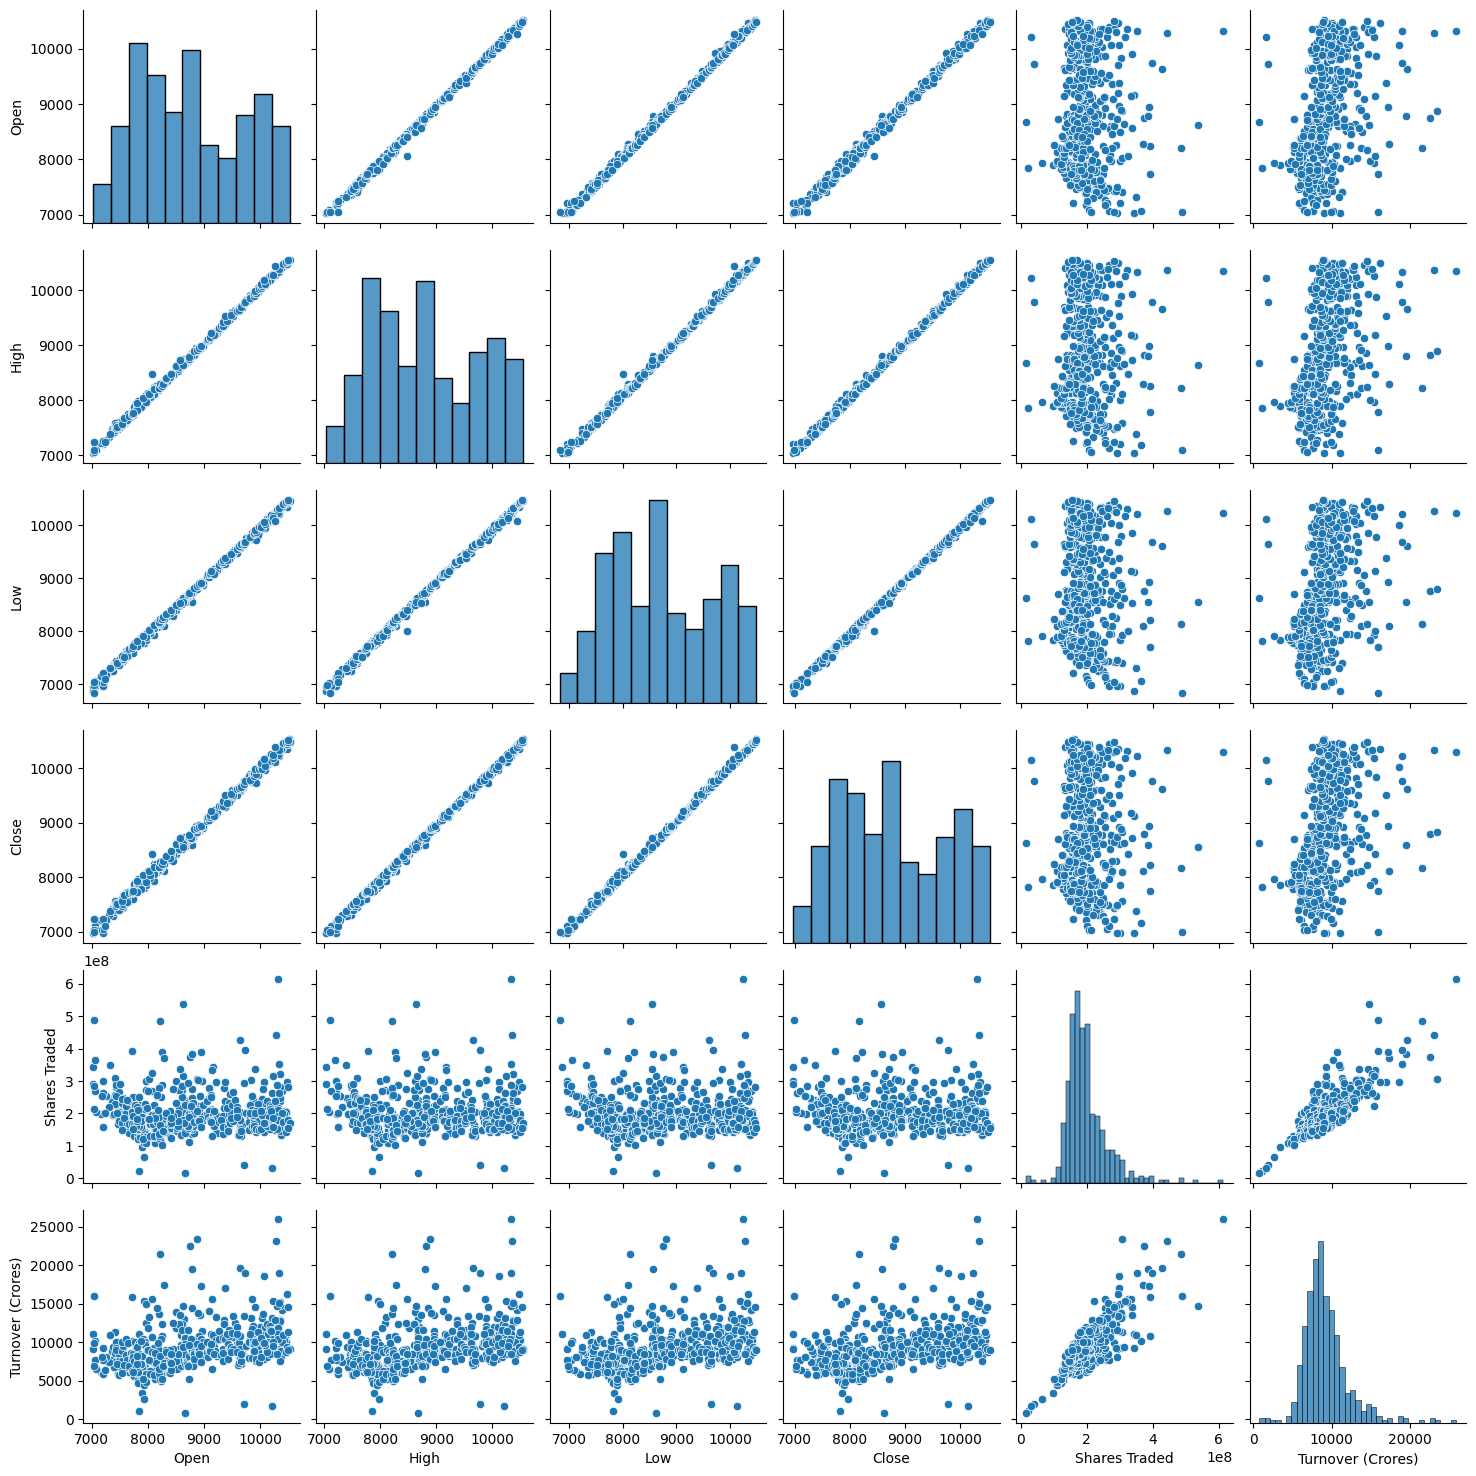

In [5]:
#visualise the data
sns.pairplot(df)
plt.show()

The pairplot reveals the pairwise relationships between numerical features in the dataset. Diagonal plots depict the distribution of each feature, while off-diagonal plots show scatter plots between feature pairs. Observations indicate strong positive correlations between `Open`, `High`, `Low`, and `Close`, indicating a consistent upward trend. A moderate positive correlation exists between `Shares Traded` and `Turnover (₹ Cr)`, implying a rise in trading volume alongside an increase in total traded value. The weak positive correlation between Date and other features suggests an overall upward trend in stock prices over the past 5 years.


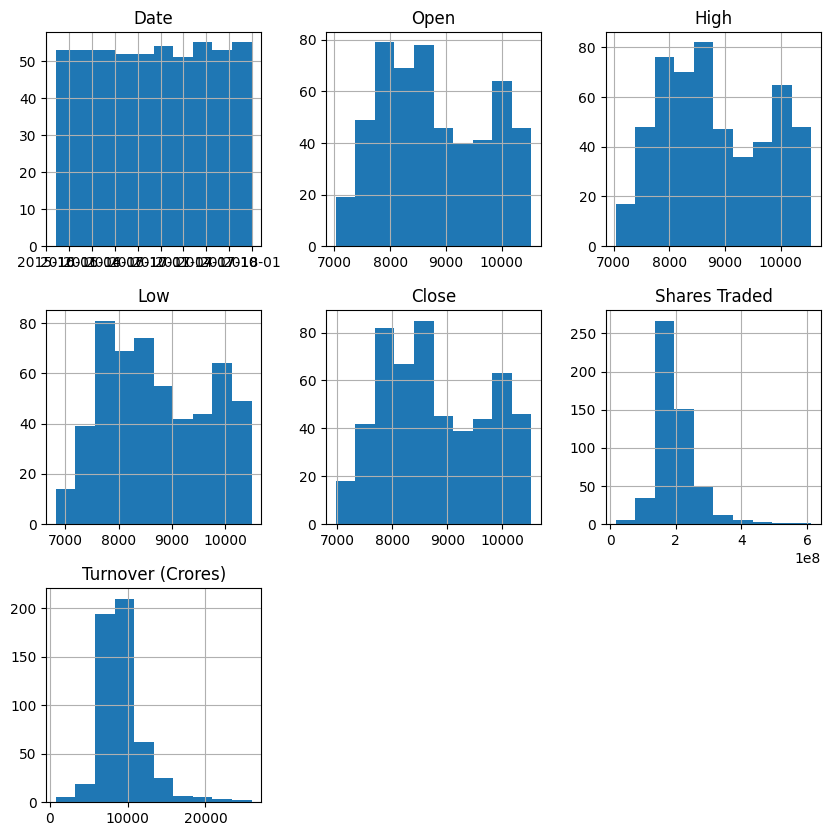

In [6]:
#show distributions in each column
df.hist(figsize=(10,10))
plt.show()

The histograms provide insights into the distribution of data across each column. The `Date` column exhibits a uniform distribution across the entire range, indicating that the stock market data covers the entire 5-year period. The `Open`, `High`, `Low`, and `Close` columns show similar distributions, with a peak in the middle and decreasing values towards the edges, suggesting a generally stable stock price with occasional fluctuations. The `Shares Traded` and `Turnover (₹ Cr)` columns exhibit right-skewed distributions, with a few data points corresponding to very high trading volumes and turnover values, a typical characteristic of stock market data.

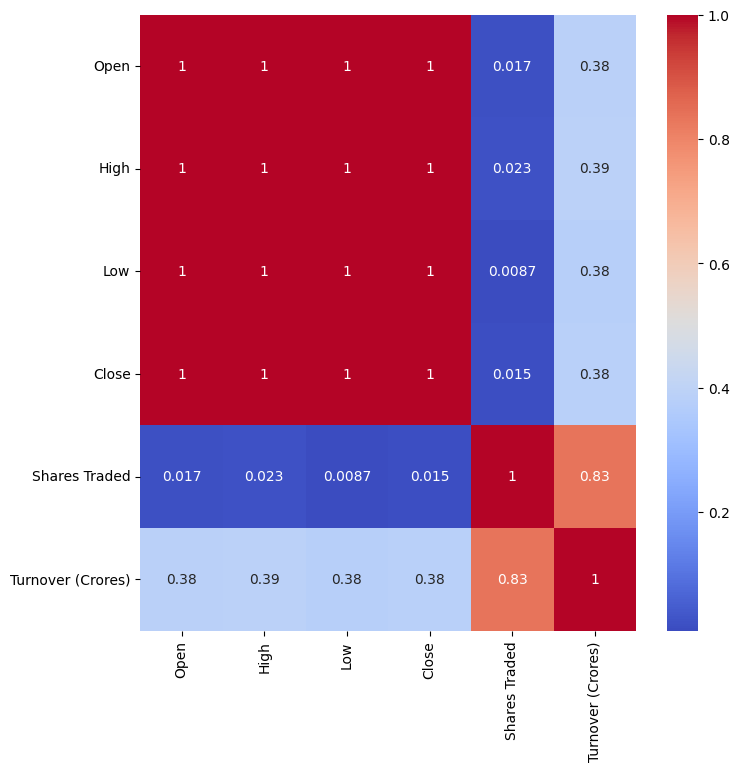

In [7]:
#plot a correlation matrix
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

Observations reveal strong positive correlations between `Open`, `High`, `Low`, and `Close`, unsurprising given their relationship to the stock price. A moderate positive correlation exists between `Shares Traded` and `Turnover (₹ Cr)`, suggesting an increase in trading volume alongside a rise in total traded value. A weak positive correlation between Date and other features indicates an overall upward trend in stock prices over the past 5 years.

In [8]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(
    title='Stock Price Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    xaxis_rangeslider_visible=False
)

fig.show()

This candlestick chart suggest that there has been an overall growth of the stock across the observed time period, with a significant dip around March 2020, which is explained by the start of the Covid-19 pandemic, after that inital fall, recovery has been immense, reaching an all time high as early as late 2020, after whhich growth continued to accelerate, with occasional, but temporary drops.

------------
## Preprocessing
We use our learnings of the dataset from above to process all the data to a trainable format. 

In [9]:
def cleanup(df):
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [10]:
def preprocess(df):
    df = cleanup(df)
    if 'Date ' in df.columns: 
        df.rename(columns={"Date ":"Date"}, inplace=True) 
    if 'Open ' in df.columns: df.rename(columns={"Open ":"Open"}, inplace=True)
    if 'High ' in df.columns: df.rename(columns={"High ":"High"}, inplace=True)
    if 'Low ' in df.columns: df.rename(columns={"Low ":"Low"}, inplace=True)
    if 'Close ' in df.columns: df.rename(columns={"Close ":"Close"}, inplace=True)
    if 'Shares Traded ' in df.columns: df.rename(columns={"Shares Traded ":"Shares Traded"}, inplace=True)
    if 'Turnover (₹ Cr)' in df.columns: df.rename(columns={"Turnover (₹ Cr)":"Turnover (Crores)"}, inplace=True)
    
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y', errors='coerce')
    
    #Feature Engineering
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayofWeek'] = df['Date'].dt.dayofweek
    df['DayofYear'] = df['Date'].dt.dayofyear
    df['Open-Delta'] = df['Open'] - df['Open'].shift(1)
    df['Volume-Delta'] = df['Shares Traded'] - df['Shares Traded'].shift(1)
    df['Turnover-Delta'] = df['Turnover (Crores)'] - df['Turnover (Crores)'].shift(1)
    
    # Additional Features
    df['Open-Percent-Change'] = (df['Open'] - df['Open'].shift(1)) / df['Open'].shift(1) * 100
    df['Volume-Percent-Change'] = (df['Shares Traded'] - df['Shares Traded'].shift(1)) / df['Shares Traded'].shift(1) * 100
    df['Turnover-Percent-Change'] = (df['Turnover (Crores)'] - df['Turnover (Crores)'].shift(1)) / df['Turnover (Crores)'].shift(1) * 100

    window_size = 5
    df['Open-Moving-Avg'] = df['Open'].rolling(window=window_size).mean()
    df['Volume-Moving-Avg'] = df['Shares Traded'].rolling(window=window_size).mean()
    df['Turnover-Moving-Avg'] = df['Turnover (Crores)'].rolling(window=window_size).mean()

    #df = pd.get_dummies(df, columns=['DayofWeek', 'Month'], drop_first=True)

    df.drop(columns=['Date'], inplace=True)
    df.fillna(0, inplace=True)
    df = cleanup(df)
    
    return df

df = preprocess(df)

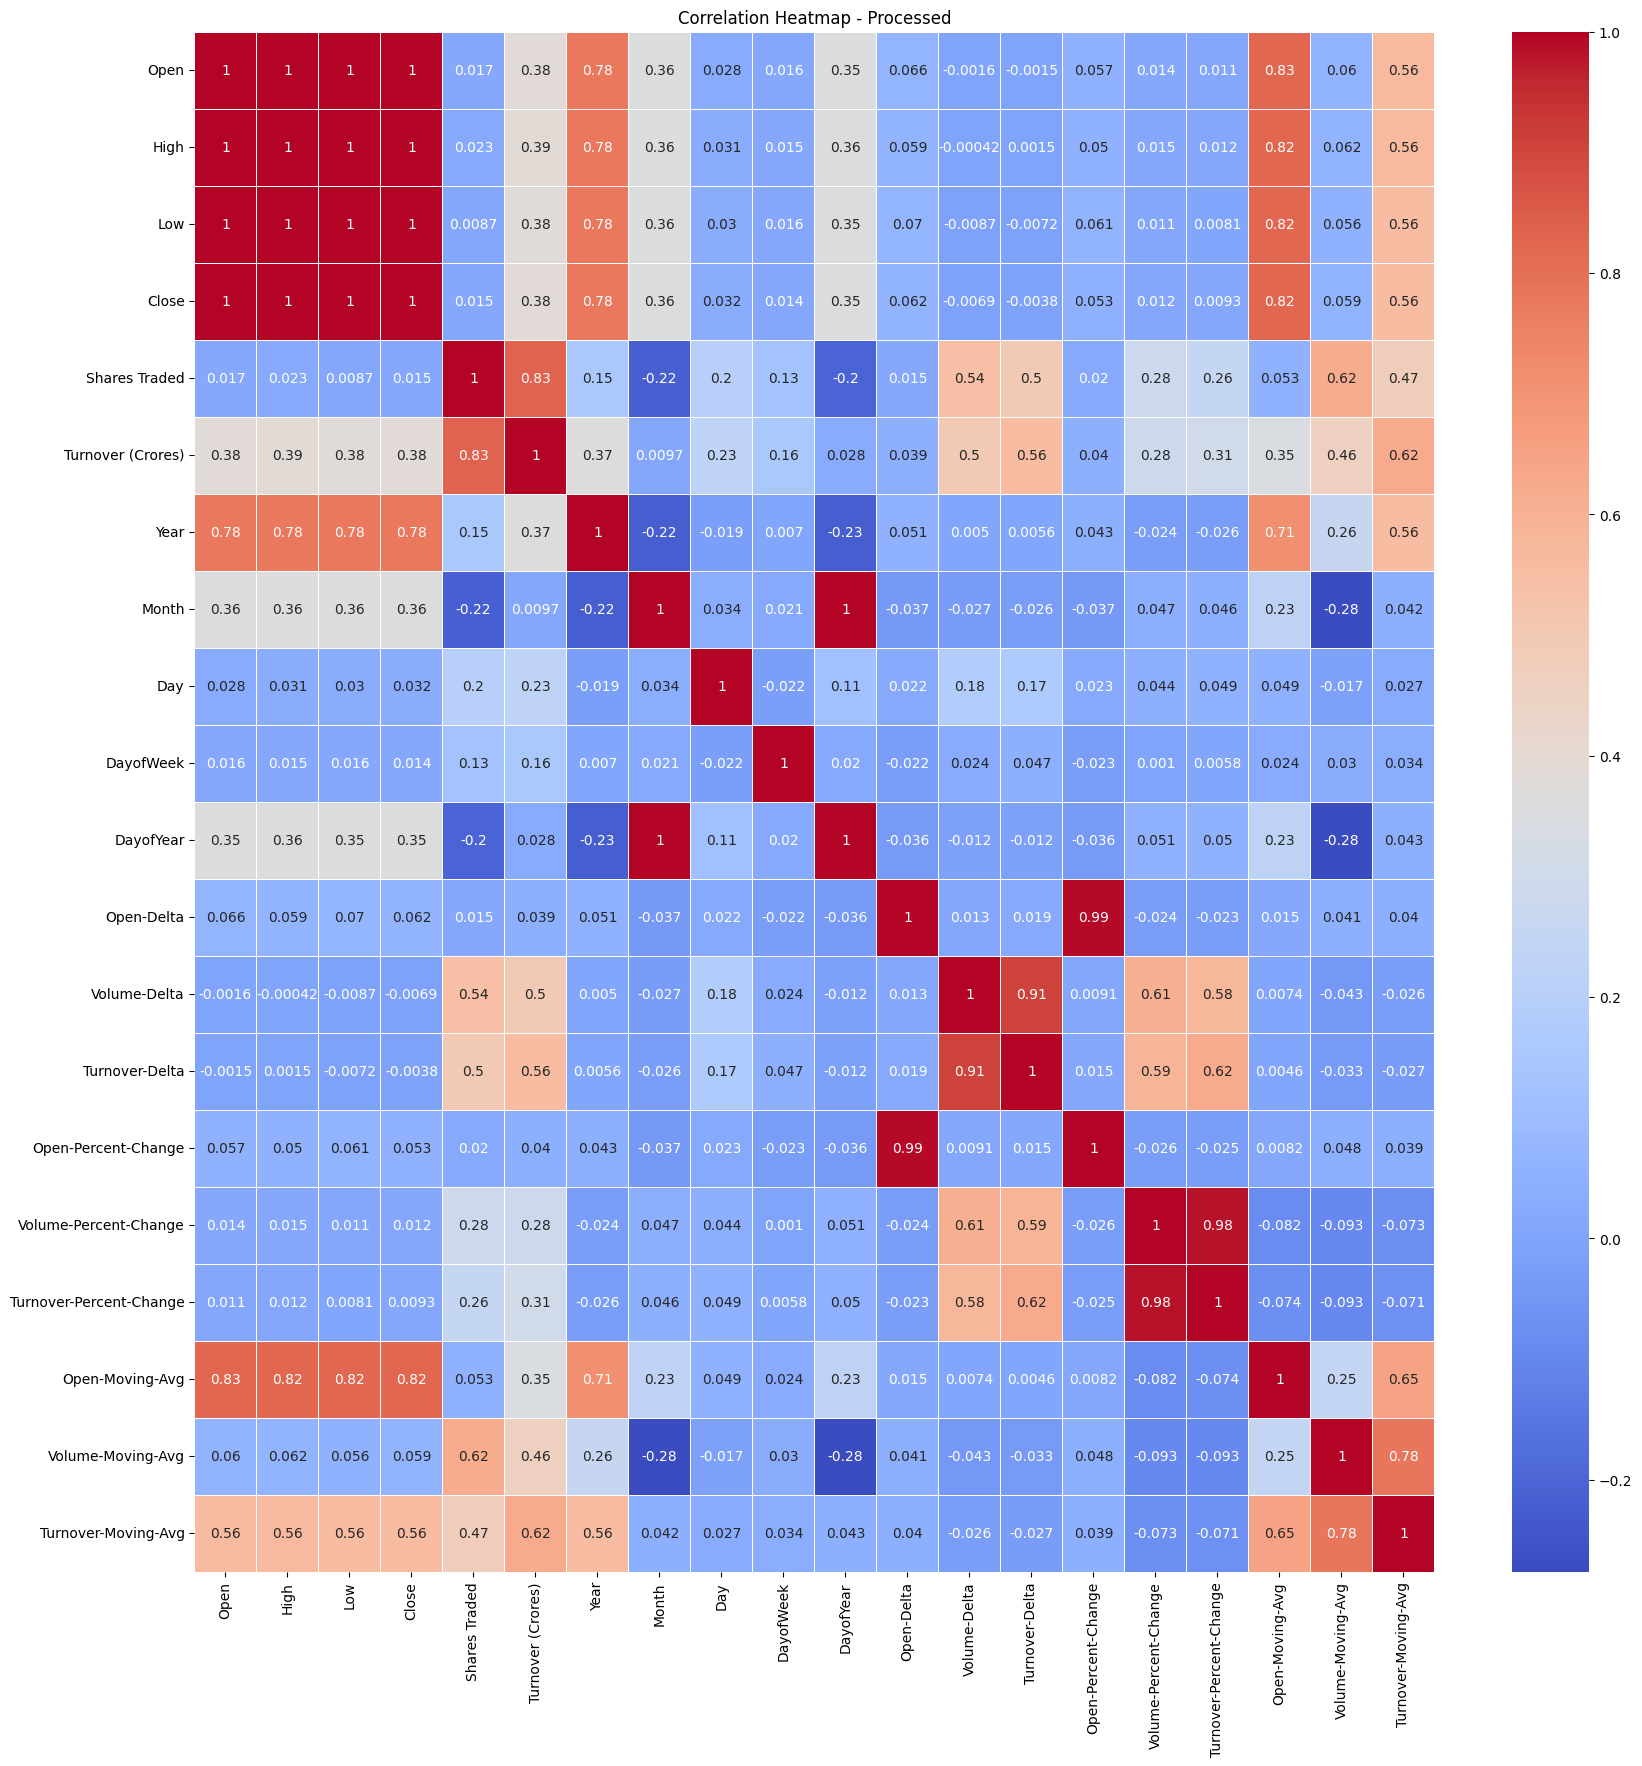

Most correlated features: {'Volume-Percent-Change', 'Volume-Delta', 'Close', 'Shares Traded', 'Turnover (Crores)', 'DayofYear', 'Low', 'Volume-Moving-Avg', 'High', 'Day', 'Open-Percent-Change', 'Open-Moving-Avg', 'Turnover-Delta', 'Turnover-Moving-Avg', 'Month', 'Turnover-Percent-Change', 'Open', 'Year', 'Open-Delta'}


In [11]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(len(df.columns),len(df.columns)))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - Processed')
plt.show()

# Set the correlation threshold
correlation_threshold = 0.2  # Adjust this threshold as needed

# Create a set to store the highly correlated features
highly_correlated_features = set()

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            # Add the feature names to the set
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            highly_correlated_features.add(feature_i)
            highly_correlated_features.add(feature_j)

# Print the highly correlated features
print("Most correlated features:", highly_correlated_features)

After preprocessing our data, we plot another correlation matrix to find the variables with correlation. We can see that `Volume-Delta`, `Low`, `High`, `Turnover (Crores)`, `Day`, `Open`, `Close`, `Year`, `Shares Traded`, `Month`, `Turnover-Delta`, and `DayofYear` are most correlated

--------------------------------
## Post Processing EDA
We re-examine our data to notice its current state, beforw it can be used in training.

In [12]:
selected_features = list(set(highly_correlated_features).union(set(['High','Low','Close'])))
df = df[selected_features]
eda(df, skipvisual=True)

Head:


Open-Moving-Avg  Volume-Percent-Change  Volume-Delta    Close  \
0             0.00               0.000000           0.0  7915.20   
1             0.00             -22.046721   -48154975.0  7783.35   
2             0.00             -86.855714  -147886978.0  7825.00   
3             0.00             641.168878   143496384.0  7762.25   
4          7800.01              -7.078707   -11741934.0  7806.60   
5          7812.11              -3.038685    -4683674.0  7837.55   
6          7801.22              -0.945787    -1413490.0  7731.80   
7          7791.16              -7.656969   -11335203.0  7842.75   
8          7807.05              14.562947    19907915.0  7856.55   
9          7834.36             -16.434940   -25738830.0  7849.25   

   Shares Traded  Turnover (Crores)  Turnover-Delta  Turnover-Moving-Avg  \
0      218422388            9376.17            0.00                0.000   
1      170267413            7153.47        -2222.70                0.000   
2       22380435            1123.44        -6030.03                0.000   
3      165876819            7731.55         6608.11                0.000   
4      154134885            6871.15         -860.40             6451.156   
5      149451211            6367.14         -504.01             5849.350   
6      148037721            6112.32         -254.82             5641.120   
7      136702518            7410.15         1297.83             6898.462   
8      156610433            7298.01         -112.14             6811.754   
9      130871603            6099.09        -1198.92             6657.342   

   Month  DayofYear      Low  Turnover-Percent-Change  Year  \
0     11        313  7771.70                 0.000000  2015   
1     11        314  7772.85               -23.705842  2015   
2     11        315  7819.10               -84.295174  2015   
3     11        317  7730.90               588.203197  2015   
4     11        320  7714.15               -11.128428  2015   
5     11        321  7793.00                -7.335162  2015   
6     11        322  7725.05                -4.002111  2015   
7     11        323  7765.45                21.233018  2015   
8     11        324  7817.80                -1.513330  2015   
9     11        327  7825.20               -16.428040  2015   

   Volume-Moving-Avg     Open     High  Open-Delta  Day  Open-Percent-Change  
0                0.0  7788.25  7937.75        0.00    9             0.000000  
1                0.0  7877.60  7885.10       89.35   10             1.147241  
2                0.0  7838.80  7847.95      -38.80   11            -0.492536  
3                0.0  7762.45  7775.10      -76.35   13            -0.974001  
4        146216388.0  7732.95  7838.85      -29.50   16            -0.380035  
5        132422152.6  7848.75  7860.45      115.80   17             1.497488  
6        127976214.2  7823.15  7843.40      -25.60   18            -0.326167  
7        150840630.8  7788.50  7854.90      -34.65   19            -0.442916  
8        148987353.6  7841.90  7906.95       53.40   20             0.685626  
9        144334697.2  7869.50  7877.50       27.60   23             0.351956

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Open-Moving-Avg          531 non-null    float64
 1   Volume-Percent-Change    531 non-null    float64
 2   Volume-Delta             531 non-null    float64
 3   Close                    531 non-null    float64
 4   Shares Traded            531 non-null    int64  
 5   Turnover (Crores)        531 non-null    float64
 6   Turnover-Delta           531 non-null    float64
 7   Turnover-Moving-Avg      531 non-null    float64
 8   Month                    531 non-null    int64  
 9   DayofYear                531 non-null    int64  
 10  Low                      531 non-null    float64
 11  Turnover-Percent-Change  531 non-null    float64
 12  Year                     531 non-null    int64  
 13  Volume-Moving-Avg        531 non-null    float64
 14  Open                     5

Open-Moving-Avg  Volume-Percent-Change  Volume-Delta         Close  \
count       531.000000             531.000000  5.310000e+02    531.000000   
mean       8710.502166               7.993546 -1.161698e+05   8773.505932   
std        1199.874363              65.468540  6.907235e+07    937.374987   
min           0.000000             -90.817958 -2.852739e+08   6970.600000   
25%        7924.745000             -14.417506 -2.900745e+07   7962.925000   
50%        8656.690000              -0.401312 -5.790040e+05   8659.100000   
75%        9628.445000              16.196435  2.849156e+07   9627.275000   
max       10498.240000             923.841464  3.887064e+08  10531.500000   

       Shares Traded  Turnover (Crores)  Turnover-Delta  Turnover-Moving-Avg  \
count   5.310000e+02         531.000000      531.000000           531.000000   
mean    1.987806e+08        9231.812015       -0.815574          9165.684094   
std     6.344606e+07        2921.733690     3268.454739          2110.657140   
min     1.661087e+07         805.890000   -15599.050000             0.000000   
25%     1.602093e+08        7545.460000    -1329.065000          7848.364000   
50%     1.877574e+08        8718.020000     -119.270000          9140.534000   
75%     2.211603e+08       10344.315000     1244.620000         10348.070000   
max     6.126208e+08       25922.510000    14382.780000         17919.326000   

            Month   DayofYear           Low  Turnover-Percent-Change  \
count  531.000000  531.000000    531.000000               531.000000   
mean     6.881356  194.340866   8732.986817                 8.170451   
std      3.569664  109.356655    941.976433                66.053564   
min      1.000000    1.000000   6825.800000               -90.999383   
25%      4.000000   99.500000   7919.600000               -14.067387   
50%      7.000000  197.000000   8616.250000                -1.513330   
75%     10.000000  296.500000   9607.750000                15.436665   
max     12.000000  365.000000  10488.650000               947.450645   

              Year  Volume-Moving-Avg          Open          High  Open-Delta  \
count   531.000000       5.310000e+02    531.000000    531.000000  531.000000   
mean   2016.399247       1.974371e+08   8779.528249   8812.922976    5.092467   
std       0.613311       4.641440e+07    938.710199    933.587710   71.719640   
min    2015.000000       0.000000e+00   7023.650000   7034.200000 -472.500000   
25%    2016.000000       1.701070e+08   7966.250000   7991.500000  -35.725000   
50%    2016.000000       1.910439e+08   8667.000000   8689.400000    4.250000   
75%    2017.000000       2.196317e+08   9640.600000   9650.550000   46.900000   
max    2017.000000       3.724142e+08  10531.050000  10552.400000  488.100000   

              Day  Open-Percent-Change  
count  531.000000           531.000000  
mean    15.832392             0.059810  
std      8.812950             0.857696  
min      1.000000            -5.532787  
25%      8.000000            -0.414134  
50%     16.000000             0.049791  
75%     23.000000             0.525726  
max     31.000000             6.050201

Null values
 Open-Moving-Avg            0
Volume-Percent-Change      0
Volume-Delta               0
Close                      0
Shares Traded              0
Turnover (Crores)          0
Turnover-Delta             0
Turnover-Moving-Avg        0
Month                      0
DayofYear                  0
Low                        0
Turnover-Percent-Change    0
Year                       0
Volume-Moving-Avg          0
Open                       0
High                       0
Open-Delta                 0
Day                        0
Open-Percent-Change        0
dtype: int64 
Dupicates: 0 


--------------------------------------------
## Training, Testing and Validation
We train the data on various models, sampling techniques and assess their performances

### Setup

In [13]:
from sklearn.preprocessing import MinMaxScaler

#Splitting the dataset
X = df.drop(['High','Low','Close'], axis=1).copy()
y = df[['High','Low','Close']].copy()

#Scaling the split data
x_cols = X.columns
y_cols = y.columns
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = pd.DataFrame(X_scaler.fit_transform(X), columns=x_cols)
y = pd.DataFrame(y_scaler.fit_transform(y), columns=y_cols)

eda(X, skipvisual=True)
eda(y, skipvisual=True)


Head:


Open-Moving-Avg  Volume-Percent-Change  Volume-Delta  Shares Traded  \
0         0.000000               0.089506      0.423267       0.338604   
1         0.000000               0.067778      0.351819       0.257809   
2         0.000000               0.003905      0.203844       0.009680   
3         0.000000               0.721411      0.636176       0.250442   
4         0.742983               0.082529      0.405846       0.230741   
5         0.744135               0.086511      0.416318       0.222883   
6         0.743098               0.088574      0.421170       0.220511   
7         0.742140               0.081960      0.406449       0.201493   
8         0.743653               0.103858      0.452805       0.234895   
9         0.746255               0.073308      0.385078       0.191709   

   Turnover (Crores)  Turnover-Delta  Turnover-Moving-Avg     Month  \
0           0.341219        0.520283             0.000000  0.909091   
1           0.252724        0.446149             0.000000  0.909091   
2           0.012643        0.319161             0.000000  0.909091   
3           0.275740        0.740687             0.000000  0.909091   
4           0.241484        0.491586             0.360011  0.909091   
5           0.221417        0.503473             0.326427  0.909091   
6           0.211272        0.511784             0.314806  0.909091   
7           0.262944        0.563571             0.384973  0.909091   
8           0.258479        0.516543             0.380134  0.909091   
9           0.210745        0.480295             0.371517  0.909091   

   DayofYear  Turnover-Percent-Change  Year  Volume-Moving-Avg      Open  \
0   0.857143                 0.087630   0.0           0.000000  0.217996   
1   0.859890                 0.064802   0.0           0.000000  0.243471   
2   0.862637                 0.006456   0.0           0.000000  0.232409   
3   0.868132                 0.654054   0.0           0.000000  0.210640   
4   0.876374                 0.076914   0.0           0.392618  0.202230   
5   0.879121                 0.080566   0.0           0.355578  0.235245   
6   0.881868                 0.083776   0.0           0.343639  0.227947   
7   0.884615                 0.108077   0.0           0.405035  0.218068   
8   0.887363                 0.086173   0.0           0.400058  0.233292   
9   0.895604                 0.071810   0.0           0.387565  0.241162   

   Open-Delta       Day  Open-Percent-Change  
0    0.491880  0.266667             0.477665  
1    0.584895  0.300000             0.576710  
2    0.451489  0.333333             0.435143  
3    0.412399  0.400000             0.393576  
4    0.461170  0.500000             0.444855  
5    0.612430  0.533333             0.606948  
6    0.465230  0.566667             0.449506  
7    0.455809  0.600000             0.439426  
8    0.547470  0.633333             0.536857  
9    0.520612  0.733333             0.508050

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Open-Moving-Avg          531 non-null    float64
 1   Volume-Percent-Change    531 non-null    float64
 2   Volume-Delta             531 non-null    float64
 3   Shares Traded            531 non-null    float64
 4   Turnover (Crores)        531 non-null    float64
 5   Turnover-Delta           531 non-null    float64
 6   Turnover-Moving-Avg      531 non-null    float64
 7   Month                    531 non-null    float64
 8   DayofYear                531 non-null    float64
 9   Turnover-Percent-Change  531 non-null    float64
 10  Year                     531 non-null    float64
 11  Volume-Moving-Avg        531 non-null    float64
 12  Open                     531 non-null    float64
 13  Open-Delta               531 non-null    float64
 14  Day                      5

Open-Moving-Avg  Volume-Percent-Change  Volume-Delta  Shares Traded  \
count       531.000000             531.000000    531.000000     531.000000   
mean          0.829711               0.097384      0.423095       0.305649   
std           0.114293               0.064523      0.102484       0.106451   
min           0.000000               0.000000      0.000000       0.000000   
25%           0.754864               0.075297      0.380228       0.240933   
50%           0.824585               0.089110      0.422408       0.287154   
75%           0.917148               0.105468      0.465541       0.343198   
max           1.000000               1.000000      1.000000       1.000000   

       Turnover (Crores)  Turnover-Delta  Turnover-Moving-Avg       Month  \
count         531.000000      531.000000           531.000000  531.000000   
mean            0.335472        0.520256             0.511497    0.534669   
std             0.116327        0.109015             0.117787    0.324515   
min             0.000000        0.000000             0.000000    0.000000   
25%             0.268331        0.475954             0.437983    0.272727   
50%             0.315016        0.516305             0.510094    0.545455   
75%             0.379765        0.561796             0.577481    0.818182   
max             1.000000        1.000000             1.000000    1.000000   

        DayofYear  Turnover-Percent-Change        Year  Volume-Moving-Avg  \
count  531.000000               531.000000  531.000000         531.000000   
mean     0.531156                 0.095498    0.699623           0.530155   
std      0.300430                 0.063608    0.306655           0.124631   
min      0.000000                 0.000000    0.000000           0.000000   
25%      0.270604                 0.074083    0.500000           0.456768   
50%      0.538462                 0.086173    0.500000           0.512988   
75%      0.811813                 0.102495    1.000000           0.589751   
max      1.000000                 1.000000    1.000000           1.000000   

             Open  Open-Delta         Day  Open-Percent-Change  
count  531.000000  531.000000  531.000000           531.000000  
mean     0.500621    0.497181    0.494413             0.482829  
std      0.267637    0.074661    0.293765             0.074048  
min      0.000000    0.000000    0.000000             0.000000  
25%      0.268746    0.454690    0.233333             0.441911  
50%      0.468538    0.496304    0.500000             0.481963  
75%      0.746122    0.540704    0.733333             0.523053  
max      1.000000    1.000000    1.000000             1.000000

Null values
 Open-Moving-Avg            0
Volume-Percent-Change      0
Volume-Delta               0
Shares Traded              0
Turnover (Crores)          0
Turnover-Delta             0
Turnover-Moving-Avg        0
Month                      0
DayofYear                  0
Turnover-Percent-Change    0
Year                       0
Volume-Moving-Avg          0
Open                       0
Open-Delta                 0
Day                        0
Open-Percent-Change        0
dtype: int64 
Dupicates: 0 
Head:


High       Low     Close
0  0.256822  0.258242  0.265270
1  0.241857  0.258555  0.228243
2  0.231297  0.271182  0.239939
3  0.210591  0.247103  0.222317
4  0.228711  0.242530  0.234772
5  0.234850  0.264057  0.243464
6  0.230004  0.245506  0.213766
7  0.233273  0.256535  0.244924
8  0.248067  0.270827  0.248799
9  0.239696  0.272848  0.246749

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    531 non-null    float64
 1   Low     531 non-null    float64
 2   Close   531 non-null    float64
dtypes: float64(3)
memory usage: 12.6 KB
Info: None =========================
Description:


High         Low       Close
count  531.000000  531.000000  531.000000
mean     0.505578    0.520684    0.506306
std      0.265359    0.257170    0.263241
min      0.000000    0.000000    0.000000
25%      0.272099    0.298620    0.278673
50%      0.470468    0.488813    0.474178
75%      0.743662    0.759504    0.746068
max      1.000000    1.000000    1.000000

Null values
 High     0
Low      0
Close    0
dtype: int64 
Dupicates: 0 


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_test:",X_test.shape,"y_test:",y_test.shape)

best_model_overall = None
best_model_name_overall = None
best_rmse_overall = float('inf')
best_rmse_descaled = float('inf')

X_train: (424, 16) y_train: (424, 3) X_test: (107, 16) y_test: (107, 3)


In [15]:
def print_results(y_test, y_pred, delta=0, realvals=1): 
    y_pred_df = pd.DataFrame(y_pred, columns=['High', 'Low', 'Close'])
    y_test_reset = y_test.reset_index(drop=True)
    y_pred_df_reset = y_pred_df.reset_index(drop=True)
    if realvals==1:
        y_test_reset = pd.DataFrame(y_scaler.inverse_transform(y_test_reset), columns=['High', 'Low', 'Close'])
        y_pred_df_reset = pd.DataFrame(y_scaler.inverse_transform(y_pred_df_reset), columns=['High', 'Low', 'Close'])
        mae = mean_absolute_error(y_test_reset, y_pred_df_reset)
        mse = mean_squared_error(y_test_reset, y_pred_df_reset)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_reset, y_pred_df_reset)
        print(f"Descaled metrics - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f}")
        
    if delta==0:
        result_df = pd.concat([y_test_reset.round(2), y_pred_df_reset.round(2)], axis=1, keys=['Original', 'Prediction'])
        columns = pd.MultiIndex.from_product([['Original', 'Prediction'], ['High', 'Low', 'Close']], names=['Type', 'Variable'])
        result_df.columns = columns
        display(result_df.head(5))
    else:
        y_diff = abs(y_test_reset - y_pred_df_reset)
        result_df = pd.concat([y_test_reset.round(2), y_pred_df_reset.round(2), y_diff.round(2)], axis=1, keys=['Original', 'Prediction', 'Delta'])
        columns = pd.MultiIndex.from_product([['Original', 'Prediction', 'Delta'], ['High', 'Low', 'Close']], names=['Type', 'Variable'])
        result_df.columns = columns
        display(result_df.head(5))
        print("Delta:")
        display(result_df['Delta'].describe())

### Direct training

In [16]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, MultiTaskElasticNet
from xgboost import XGBRegressor

models = [
    (MultiOutputRegressor(RandomForestRegressor(random_state=42)), 'Random Forest Regressor'),
    (MultiOutputRegressor(GradientBoostingRegressor(random_state=42)), 'Gradient Boosting Regressor'),
    (MultiOutputRegressor(KNeighborsRegressor()), 'K Neighbors Regressor'),
    (MultiOutputRegressor(LinearRegression()), 'Linear Regression'),
    (MultiOutputRegressor(XGBRegressor(random_state=42)), 'XGB Regressor'),
    (MultiOutputRegressor(AdaBoostRegressor(random_state=42)), 'AdaBoost Regressor'),
    (MultiTaskElasticNet(random_state=42, max_iter=50000), 'MultiTaskElasticNet')
    #,(MLPRegressor(random_state=42, max_iter=50000), 'MLPRegressor')
]

# Evaluate and print model performance
for model, model_name in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f}")
    print_results(y_test, y_pred)
    print("=============================================")

    if rmse < best_rmse_overall: 
        best_model_overall = model
        best_rmse_overall = rmse
        best_model_name_overall = model_name
        best_rmse_descaled = mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(y_pred), squared=False)

print(f"\nThe best model is {best_model_name_overall} with RMSE: {best_rmse_overall:.2f} (descaled: {best_rmse_descaled:.2f})")
best_change = "still"

Random Forest Regressor - MAE: 0.01, RMSE: 0.01, R-squared: 1.00
Descaled metrics - MAE: 38.69, RMSE: 51.05, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10362.50  10262.96  10277.77
1          7843.40   7725.05   7731.80    7841.90   7763.13   7806.75
2          8914.75   8867.60   8879.60    8950.45   8888.92   8927.42
3          9928.20   9894.70   9915.95    9916.80   9839.15   9882.20
4         10334.15  10216.25  10224.95   10357.08  10265.75  10297.59

Gradient Boosting Regressor - MAE: 0.01, RMSE: 0.01, R-squared: 1.00
Descaled metrics - MAE: 37.96, RMSE: 50.25, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10355.98  10284.86  10320.95
1          7843.40   7725.05   7731.80    7834.07   7763.62   7799.55
2          8914.75   8867.60   8879.60    8960.09   8898.78   8947.01
3          9928.20   9894.70   9915.95    9914.42   9829.86   9855.92
4         10334.15  10216.25  10224.95   10339.73  10270.47  10276.08

K Neighbors Regressor - MAE: 0.03, RMSE: 0.04, R-squared: 0.98
Descaled metrics - MAE: 98.50, RMSE: 153.79, R-squared: 0.98


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10169.91  10078.30  10143.46
1          7843.40   7725.05   7731.80    7847.55   7761.23   7818.87
2          8914.75   8867.60   8879.60    8880.25   8816.17   8855.13
3          9928.20   9894.70   9915.95    9757.58   9701.77   9719.62
4         10334.15  10216.25  10224.95   10274.59  10193.37  10239.59

Linear Regression - MAE: 0.01, RMSE: 0.01, R-squared: 1.00
Descaled metrics - MAE: 32.38, RMSE: 43.64, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10321.39  10277.36  10296.71
1          7843.40   7725.05   7731.80    7860.34   7776.28   7819.31
2          8914.75   8867.60   8879.60    8935.40   8833.61   8871.82
3          9928.20   9894.70   9915.95    9931.33   9870.68   9902.09
4         10334.15  10216.25  10224.95   10343.66  10268.95  10300.09

XGB Regressor - MAE: 0.01, RMSE: 0.02, R-squared: 1.00
Descaled metrics - MAE: 41.90, RMSE: 55.30, R-squared: 1.00


Type      Original                        Prediction                \
Variable      High       Low     Close          High           Low   
0         10329.20  10282.05  10322.25  10256.250000  10273.549805   
1          7843.40   7725.05   7731.80   7835.830078   7760.629883   
2          8914.75   8867.60   8879.60   8924.009766   8890.059570   
3          9928.20   9894.70   9915.95   9927.849609   9826.370117   
4         10334.15  10216.25  10224.95  10345.059570  10272.129883   

Type                    
Variable         Close  
0         10329.980469  
1          7808.970215  
2          8905.660156  
3          9887.679688  
4         10341.139648

AdaBoost Regressor - MAE: 0.01, RMSE: 0.02, R-squared: 1.00
Descaled metrics - MAE: 49.97, RMSE: 61.75, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10348.99  10294.68  10277.80
1          7843.40   7725.05   7731.80    7885.35   7772.45   7802.59
2          8914.75   8867.60   8879.60    8980.94   8960.35   8961.06
3          9928.20   9894.70   9915.95    9978.62   9828.00   9902.60
4         10334.15  10216.25  10224.95   10352.40  10307.44  10293.74

MultiTaskElasticNet - MAE: 0.24, RMSE: 0.28, R-squared: -0.00
Descaled metrics - MAE: 862.27, RMSE: 1013.86, R-squared: -0.00


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25     8823.8  8743.32  8783.05
1          7843.40   7725.05   7731.80     8823.8  8743.32  8783.05
2          8914.75   8867.60   8879.60     8823.8  8743.32  8783.05
3          9928.20   9894.70   9915.95     8823.8  8743.32  8783.05
4         10334.15  10216.25  10224.95     8823.8  8743.32  8783.05


The best model is Linear Regression with RMSE: 0.01 (descaled: 42.70)


### Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the models and their respective parameters
models = [
    ((RandomForestRegressor(),), 'Random Forest Regressor', {'estimator__n_estimators': [50, 100, 150], 'estimator__max_depth': [None, 5, 10]}),
    ((GradientBoostingRegressor(),), 'Gradient Boosting Regressor', {'estimator__n_estimators': [50, 100, 150], 'estimator__learning_rate': [0.1, 0.01, 0.001]}),
    ((KNeighborsRegressor(),), 'K Neighbors Regressor', {'estimator__n_neighbors': [3, 5, 7]}),
    ((LinearRegression(),), 'Linear Regression', {}),
    ((XGBRegressor(),), 'XGB Regressor', {'estimator__n_estimators': [50, 100, 150], 'estimator__learning_rate': [0.1, 0.01, 0.001]}),
    ((AdaBoostRegressor(),), 'AdaBoost Regressor', {'estimator__n_estimators': [50, 100, 150], 'estimator__learning_rate': [0.1, 0.01, 0.001]}),
    ((MultiTaskElasticNet(random_state=42, max_iter=50000),), 'ElasticNet', {'alpha': [1, 0.5, 0.1], 'l1_ratio': [0.1, 0.5, 0.9]})
    #,((MLPRegressor(random_state=42, max_iter=50000),), 'MLP Regressor', {'estimator__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 
                                          #'estimator__activation': ['tanh', 'relu'], 'estimator__solver': ['sgd', 'adam'], 
                                          #'estimator__alpha': [0.0001, 0.05], 'estimator__learning_rate': ['constant','adaptive']})
]

# Evaluate and print model performance
for model, model_name, params in models:
    if isinstance(model[0], MultiTaskElasticNet):
        estimator = model[0]
    else:
        estimator = MultiOutputRegressor(model[0])

    grid = GridSearchCV(estimator, params, cv=3, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    
    y_pred = grid.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f}")
    print_results(y_test, y_pred)
    print("=============================================")

    if rmse < best_rmse_overall: 
        best_model_overall = estimator
        best_rmse_overall = rmse
        best_model_name_overall = model_name
        best_change = "now"
        best_rmse_descaled = mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(y_pred), squared=False)


print(f"The best model is {best_change} {best_model_name_overall} with RMSE: {best_rmse_overall:.2f} (descaled: {best_rmse_descaled:.2f})")
best_change = "still"

Random Forest Regressor - MAE: 0.01, RMSE: 0.01, R-squared: 1.00
Descaled metrics - MAE: 39.05, RMSE: 52.12, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10361.46  10256.67  10293.49
1          7843.40   7725.05   7731.80    7841.67   7765.79   7805.22
2          8914.75   8867.60   8879.60    8951.12   8891.47   8923.28
3          9928.20   9894.70   9915.95    9920.11   9841.55   9880.79
4         10334.15  10216.25  10224.95   10355.60  10255.34  10292.49

Gradient Boosting Regressor - MAE: 0.01, RMSE: 0.01, R-squared: 1.00
Descaled metrics - MAE: 37.62, RMSE: 50.00, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10355.98  10284.86  10320.95
1          7843.40   7725.05   7731.80    7834.07   7763.62   7799.55
2          8914.75   8867.60   8879.60    8960.09   8898.78   8947.01
3          9928.20   9894.70   9915.95    9914.42   9829.86   9855.92
4         10334.15  10216.25  10224.95   10339.73  10269.71  10276.08

K Neighbors Regressor - MAE: 0.03, RMSE: 0.04, R-squared: 0.98
Descaled metrics - MAE: 98.33, RMSE: 144.81, R-squared: 0.98


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10187.57  10098.75  10168.83
1          7843.40   7725.05   7731.80    7866.90   7765.80   7835.30
2          8914.75   8867.60   8879.60    9042.02   8989.72   9013.38
3          9928.20   9894.70   9915.95    9819.08   9756.57   9779.23
4         10334.15  10216.25  10224.95   10258.72  10166.72  10213.92

Linear Regression - MAE: 0.01, RMSE: 0.01, R-squared: 1.00
Descaled metrics - MAE: 32.38, RMSE: 43.64, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10321.39  10277.36  10296.71
1          7843.40   7725.05   7731.80    7860.34   7776.28   7819.31
2          8914.75   8867.60   8879.60    8935.40   8833.61   8871.82
3          9928.20   9894.70   9915.95    9931.33   9870.68   9902.09
4         10334.15  10216.25  10224.95   10343.66  10268.95  10300.09

XGB Regressor - MAE: 0.01, RMSE: 0.02, R-squared: 1.00
Descaled metrics - MAE: 41.13, RMSE: 56.45, R-squared: 1.00


Type      Original                        Prediction                \
Variable      High       Low     Close          High           Low   
0         10329.20  10282.05  10322.25  10301.370117  10261.740234   
1          7843.40   7725.05   7731.80   7853.240234   7764.680176   
2          8914.75   8867.60   8879.60   8920.240234   8862.009766   
3          9928.20   9894.70   9915.95   9909.230469   9836.429688   
4         10334.15  10216.25  10224.95  10344.089844  10270.589844   

Type                    
Variable         Close  
0         10297.980469  
1          7810.129883  
2          8893.259766  
3          9871.530273  
4         10298.509766

AdaBoost Regressor - MAE: 0.02, RMSE: 0.02, R-squared: 1.00
Descaled metrics - MAE: 56.76, RMSE: 71.22, R-squared: 1.00


Type      Original                     Prediction                    
Variable      High       Low     Close       High       Low     Close
0         10329.20  10282.05  10322.25   10374.20  10280.39  10317.61
1          7843.40   7725.05   7731.80    7840.80   7772.84   7789.54
2          8914.75   8867.60   8879.60    8944.45   8953.10   8933.74
3          9928.20   9894.70   9915.95    9987.75   9910.97   9920.48
4         10334.15  10216.25  10224.95   10379.52  10287.95  10317.61

ElasticNet - MAE: 0.11, RMSE: 0.13, R-squared: 0.79
Descaled metrics - MAE: 380.11, RMSE: 459.94, R-squared: 0.79


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25    9690.57  9614.26  9651.65
1          7843.40   7725.05   7731.80    8147.05  8059.61  8103.07
2          8914.75   8867.60   8879.60    8908.54  8830.79  8869.04
3          9928.20   9894.70   9915.95    9381.93  9305.71  9343.04
4         10334.15  10216.25  10224.95    9669.57  9593.37  9630.61

The best model is still Linear Regression with RMSE: 0.01 (descaled: 42.70)


In [18]:
models = [
    ((RandomForestRegressor(),), 'Random Forest Regressor', {'estimator__n_estimators': [50, 100, 150], 'estimator__max_depth': [None, 5, 10]}),
    ((GradientBoostingRegressor(),), 'Gradient Boosting Regressor', {'estimator__n_estimators': [50, 100, 150], 'estimator__learning_rate': [0.1, 0.01, 0.001]}),
    ((KNeighborsRegressor(),), 'K Neighbors Regressor', {'estimator__n_neighbors': [3, 5, 7]}),
    ((LinearRegression(),), 'Linear Regression', {}),
    ((XGBRegressor(),), 'XGB Regressor', {'estimator__n_estimators': [50, 100, 150], 'estimator__learning_rate': [0.1, 0.01, 0.001]}),
    ((AdaBoostRegressor(),), 'AdaBoost Regressor', {'estimator__n_estimators': [50, 100, 150], 'estimator__learning_rate': [0.1, 0.01, 0.001]}),
    ((MultiTaskElasticNet(random_state=42, max_iter=50000),), 'ElasticNet', {'alpha': [1, 0.5, 0.1], 'l1_ratio': [0.1, 0.5, 0.9]})
    #,((MLPRegressor(random_state=42, max_iter=50000),), 'MLP Regressor', {'estimator__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 
                                          #'estimator__activation': ['tanh', 'relu'], 'estimator__solver': ['sgd', 'adam'], 
                                          #'estimator__alpha': [0.0001, 0.05], 'estimator__learning_rate': ['constant','adaptive']})
]

# Evaluate and print model performance
for model, model_name, params in models:
    if isinstance(model[0], MultiTaskElasticNet):
        estimator = model[0]
    else:
        estimator = MultiOutputRegressor(model[0])
    n = len(params) if len(params) > 0 else 1
    grid = RandomizedSearchCV(estimator, params, cv=3, scoring='neg_mean_squared_error', n_iter=n, random_state=42)
    grid.fit(X_train, y_train)
    
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f}")
    print_results(y_test, y_pred)
    print("=============================================")

    if rmse < best_rmse_overall: 
        best_model_overall = estimator
        best_rmse_overall = rmse
        best_model_name_overall = model_name
        best_change = "now"
        best_rmse_descaled = mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(y_pred), squared=False)


print(f"The best model is {best_change} {best_model_name_overall} with RMSE: {best_rmse_overall:.2f} (descaled: {best_rmse_descaled:.2f})")
best_change = "still"

Random Forest Regressor - MAE: 0.11, RMSE: 0.13, R-squared: 0.79
Descaled metrics - MAE: 380.11, RMSE: 459.94, R-squared: 0.79


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25    9690.57  9614.26  9651.65
1          7843.40   7725.05   7731.80    8147.05  8059.61  8103.07
2          8914.75   8867.60   8879.60    8908.54  8830.79  8869.04
3          9928.20   9894.70   9915.95    9381.93  9305.71  9343.04
4         10334.15  10216.25  10224.95    9669.57  9593.37  9630.61

Gradient Boosting Regressor - MAE: 0.11, RMSE: 0.13, R-squared: 0.79
Descaled metrics - MAE: 380.11, RMSE: 459.94, R-squared: 0.79


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25    9690.57  9614.26  9651.65
1          7843.40   7725.05   7731.80    8147.05  8059.61  8103.07
2          8914.75   8867.60   8879.60    8908.54  8830.79  8869.04
3          9928.20   9894.70   9915.95    9381.93  9305.71  9343.04
4         10334.15  10216.25  10224.95    9669.57  9593.37  9630.61

K Neighbors Regressor - MAE: 0.11, RMSE: 0.13, R-squared: 0.79
Descaled metrics - MAE: 380.11, RMSE: 459.94, R-squared: 0.79


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25    9690.57  9614.26  9651.65
1          7843.40   7725.05   7731.80    8147.05  8059.61  8103.07
2          8914.75   8867.60   8879.60    8908.54  8830.79  8869.04
3          9928.20   9894.70   9915.95    9381.93  9305.71  9343.04
4         10334.15  10216.25  10224.95    9669.57  9593.37  9630.61

Linear Regression - MAE: 0.11, RMSE: 0.13, R-squared: 0.79
Descaled metrics - MAE: 380.11, RMSE: 459.94, R-squared: 0.79


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25    9690.57  9614.26  9651.65
1          7843.40   7725.05   7731.80    8147.05  8059.61  8103.07
2          8914.75   8867.60   8879.60    8908.54  8830.79  8869.04
3          9928.20   9894.70   9915.95    9381.93  9305.71  9343.04
4         10334.15  10216.25  10224.95    9669.57  9593.37  9630.61

XGB Regressor - MAE: 0.11, RMSE: 0.13, R-squared: 0.79
Descaled metrics - MAE: 380.11, RMSE: 459.94, R-squared: 0.79


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25    9690.57  9614.26  9651.65
1          7843.40   7725.05   7731.80    8147.05  8059.61  8103.07
2          8914.75   8867.60   8879.60    8908.54  8830.79  8869.04
3          9928.20   9894.70   9915.95    9381.93  9305.71  9343.04
4         10334.15  10216.25  10224.95    9669.57  9593.37  9630.61

AdaBoost Regressor - MAE: 0.11, RMSE: 0.13, R-squared: 0.79
Descaled metrics - MAE: 380.11, RMSE: 459.94, R-squared: 0.79


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25    9690.57  9614.26  9651.65
1          7843.40   7725.05   7731.80    8147.05  8059.61  8103.07
2          8914.75   8867.60   8879.60    8908.54  8830.79  8869.04
3          9928.20   9894.70   9915.95    9381.93  9305.71  9343.04
4         10334.15  10216.25  10224.95    9669.57  9593.37  9630.61

ElasticNet - MAE: 0.11, RMSE: 0.13, R-squared: 0.79
Descaled metrics - MAE: 380.11, RMSE: 459.94, R-squared: 0.79


Type      Original                     Prediction                  
Variable      High       Low     Close       High      Low    Close
0         10329.20  10282.05  10322.25    9690.57  9614.26  9651.65
1          7843.40   7725.05   7731.80    8147.05  8059.61  8103.07
2          8914.75   8867.60   8879.60    8908.54  8830.79  8869.04
3          9928.20   9894.70   9915.95    9381.93  9305.71  9343.04
4         10334.15  10216.25  10224.95    9669.57  9593.37  9630.61

The best model is still Linear Regression with RMSE: 0.01 (descaled: 42.70)


### Cross Validation

In [19]:
from sklearn.model_selection import cross_val_score

models = [
    (MultiOutputRegressor(RandomForestRegressor(random_state=42)), 'Random Forest Regressor'),
    (MultiOutputRegressor(GradientBoostingRegressor(random_state=42)), 'Gradient Boosting Regressor'),
    (MultiOutputRegressor(KNeighborsRegressor()), 'K Neighbors Regressor'),
    (MultiOutputRegressor(LinearRegression()), 'Linear Regression'),
    (MultiOutputRegressor(XGBRegressor(random_state=42)), 'XGB Regressor'),
    (MultiOutputRegressor(AdaBoostRegressor(random_state=42)), 'AdaBoost Regressor'),
    (MultiTaskElasticNet(random_state=42, max_iter=50000), 'MultiTaskElasticNet')
    #,(MLPRegressor(random_state=42, max_iter=50000), 'MLPRegressor')
]

# Evaluate models using cross-validation
for model, model_name in models:
    # Calculate RMSE for each target variable separately
    cv_scores = np.sqrt(-cross_val_score(model, X, y, cv=2, scoring='neg_mean_squared_error', error_score='raise'))
    
    # Convert negative mean squared error to positive (for consistency)
    #cv_scores = np.sqrt(-cv_scores)
    
    # Calculate metrics
    rmse_cv = np.mean(cv_scores)
    mae_cv = np.mean(-cross_val_score(model, X, y, cv=2, scoring='neg_mean_absolute_error'))
    r2_cv = np.mean(cross_val_score(model, X, y, cv=2, scoring='r2'))
    
    print(f"Model: {model_name}")
    print(f"Cross-Validation RMSE: {rmse_cv:.2f}")
    print(f"Cross-Validation MAE: {mae_cv:.2f}")
    print(f"Cross-Validation R-squared: {r2_cv:.2f}")
    print("============================")
    
    # Check if the RMSE is better than the current best
    if rmse_cv < best_rmse_overall:
        best_change = "now"
        best_model_overall = model
        best_rmse_overall = rmse_cv
        best_model_name_overall = model_name + " (Cross-Validation)"
        best_rmse_descaled = mean_squared_error(y_scaler.inverse_transform(y_test), y_scaler.inverse_transform(y_pred), squared=False)


print(f"The best model is {best_change} {best_model_name_overall} with RMSE: {best_rmse_overall:.2f} (descaled: {best_rmse_descaled:.2f})")

Model: Random Forest Regressor
Cross-Validation RMSE: 0.18
Cross-Validation MAE: 0.14
Cross-Validation R-squared: -0.14
Model: Gradient Boosting Regressor
Cross-Validation RMSE: 0.18
Cross-Validation MAE: 0.14
Cross-Validation R-squared: -0.20
Model: K Neighbors Regressor
Cross-Validation RMSE: 0.29
Cross-Validation MAE: 0.26
Cross-Validation R-squared: -2.05
Model: Linear Regression
Cross-Validation RMSE: 0.02
Cross-Validation MAE: 0.01
Cross-Validation R-squared: 0.97
Model: XGB Regressor
Cross-Validation RMSE: 0.19
Cross-Validation MAE: 0.15
Cross-Validation R-squared: -0.30
Model: AdaBoost Regressor
Cross-Validation RMSE: 0.18
Cross-Validation MAE: 0.14
Cross-Validation R-squared: -0.22
Model: MultiTaskElasticNet
Cross-Validation RMSE: 0.44
Cross-Validation MAE: 0.40
Cross-Validation R-squared: -6.46
The best model is still Linear Regression with RMSE: 0.01 (descaled: 42.70)


In [20]:
import joblib
joblib.dump(best_model_overall, 'stock_model.pkl')
joblib.dump(X_scaler, 'X_scaler.pkl')
joblib.dump(y_scaler, 'y_scaler.pkl')

['y_scaler.pkl']

------------
## Testing Against Sample data
We sample 100 random rows from the dataset to see how the model predicts the appointment time

In [21]:
data = pd.read_csv("StockMarketData2015-2019.csv")
data = preprocess(data)
# Select random rows
random_rows = data.sample(n=100, random_state=42)

random_rows = random_rows[selected_features]
random_rows = cleanup(random_rows)

X_random = random_rows.drop(['High', 'Low', 'Close'], axis=1).copy()
X_random = pd.DataFrame(X_scaler.transform(X_random), columns=X_random.columns)
y_random = random_rows[['High', 'Low', 'Close']].copy()
y_random = pd.DataFrame(y_scaler.transform(y_random), columns=y_random.columns)

# Predict using the best model
y_pred = best_model_overall.predict(X_random)

rmse_random = mean_squared_error(y_random, y_pred, squared=False)
mse_random = mean_squared_error(y_random, y_pred)
mae_random = mean_absolute_error(y_random, y_pred)
r2_random = r2_score(y_random, y_pred)

print(f"Root Mean Squared Error for the 10 random predictions: {rmse_random:.2f}")
print(f"Mean Squared Error for the 10 random predictions: {mse_random:.2f}")
print(f"Mean Absolute Error for the 10 random predictions: {mae_random:.2f}")
print(f"R-squared for the 10 random predictions: {r2_random:.2f}")

# Corrected inversion of scaling for predictions
print_results(y_random, y_pred, delta=1)

Root Mean Squared Error for the 10 random predictions: 0.01
Mean Squared Error for the 10 random predictions: 0.00
Mean Absolute Error for the 10 random predictions: 0.01
R-squared for the 10 random predictions: 1.00
Descaled metrics - MAE: 32.83, RMSE: 44.03, R-squared: 1.00


Type      Original                     Prediction                      Delta  \
Variable      High       Low     Close       High       Low     Close   High   
0         10329.20  10282.05  10322.25   10321.39  10277.36  10296.71   7.81   
1          7843.40   7725.05   7731.80    7860.34   7776.28   7819.31  16.94   
2          8914.75   8867.60   8879.60    8935.40   8833.61   8871.82  20.65   
3          9928.20   9894.70   9915.95    9931.33   9870.68   9902.09   3.13   
4         10334.15  10216.25  10224.95   10343.66  10268.95  10300.09   9.51   

Type                    
Variable    Low  Close  
0          4.69  25.54  
1         51.23  87.51  
2         33.99   7.78  
3         24.02  13.86  
4         52.70  75.14

Delta:


Variable        High         Low       Close
count     100.000000  100.000000  100.000000
mean       25.394000   31.121000   41.965800
std        23.426979   23.829237   36.750797
min         0.170000    0.000000    0.160000
25%        11.052500   15.540000   14.522500
50%        19.765000   29.145000   32.795000
75%        30.912500   40.242500   56.875000
max       135.090000  136.460000  176.210000

In [22]:
total_end = time.time()
total_time = int(total_end - total_start)
print(f"Total time elapsed: {total_time//60}m {total_time%60}s")

Total time elapsed: 1m 43s


----------
## Conclusion
We can see that after performing various techniques of training, the best possible results are given by Linear Regression with RMSE: 82.51. Upon sampling 100 random rows, we can see it similarly produces results within a 80 point error.